<a href="https://colab.research.google.com/github/bbachonko/classification-models/blob/main/NASA-nearest-objects-Hyperopt-tuning/NASA_Nearest_Earth_Objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np


In [6]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sameepvani/nasa-nearest-earth-objects

 76% 5.00M/6.60M [00:00<00:00, 42.6MB/s]
100% 6.60M/6.60M [00:00<00:00, 54.2MB/s]


In [7]:
! unzip nasa-nearest-earth-objects.zip

Archive:  nasa-nearest-earth-objects.zip
  inflating: neo.csv                 
  inflating: neo_v2.csv              


In [8]:
df_raw = pd.read_csv('neo.csv')
df = df_raw.copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [10]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [11]:
print(df.orbiting_body.value_counts())
print(df.sentry_object.value_counts())

Earth    90836
Name: orbiting_body, dtype: int64
False    90836
Name: sentry_object, dtype: int64


It it observable 2 columns in data does are qualified to be dropped. Moreover columns orbitting_body, sentry_object have only one unique value, therefore they will bu useless in model training process.

In [12]:
cols_to_drop = ['id', 'name', 'orbiting_body', 'sentry_object']
df.drop(columns=cols_to_drop, inplace=True)

Checking for nulls and duplicates.

In [13]:
df.duplicated().sum()

7

In [14]:
df.isnull().sum()

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

There is not any of these two.

We have only naumeric columns in data.

In [15]:
df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


There are a big diffrences between values between columns, checking for the variance.

In [16]:
df.var()

est_diameter_min      8.910896e-02
est_diameter_max      4.455448e-01
relative_velocity     6.397509e+08
miss_distance         4.996137e+14
absolute_magnitude    8.375731e+00
hazardous             8.784837e-02
dtype: float64

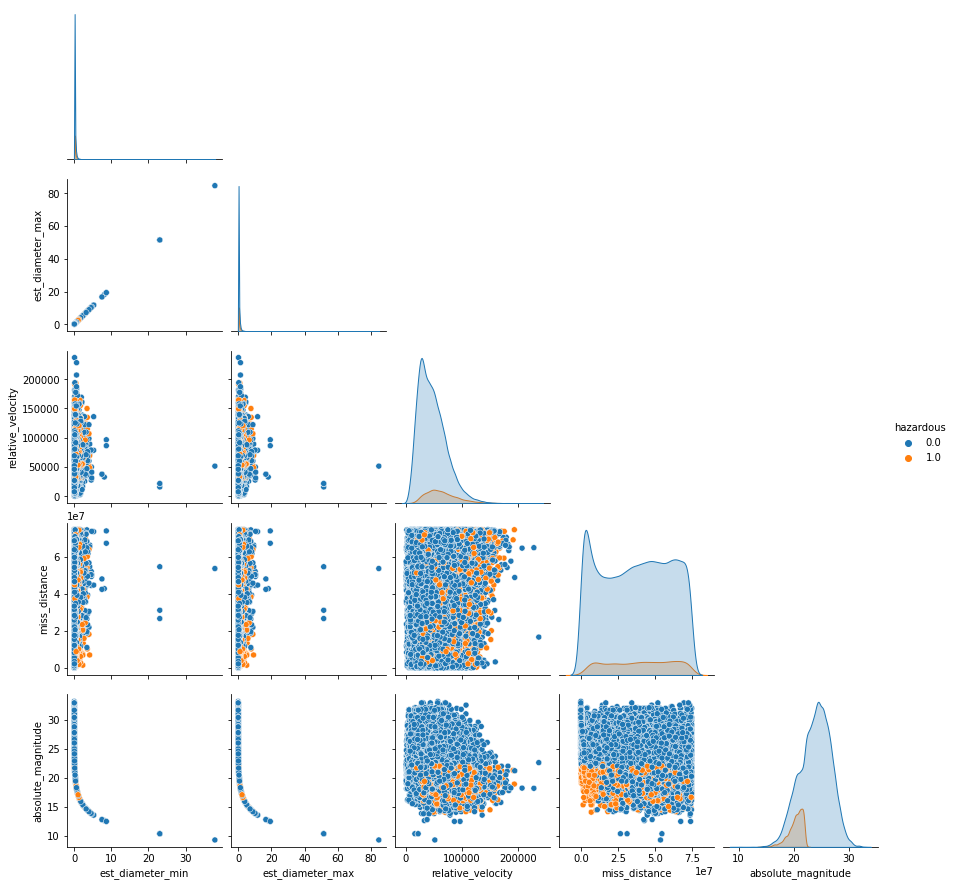

In [17]:
import seaborn as sns
#plt.fig(figsize=())
sns.pairplot(corner=True, hue='hazardous', data=df.astype(float))

Wee see some repetitive patterns in minority class occuring which are positive hazardous values. For example we have strong limit when miss_distance determines hazardous occuring. Another one is absolute magnitude column which also seems to limit positive hazard flag appearing.

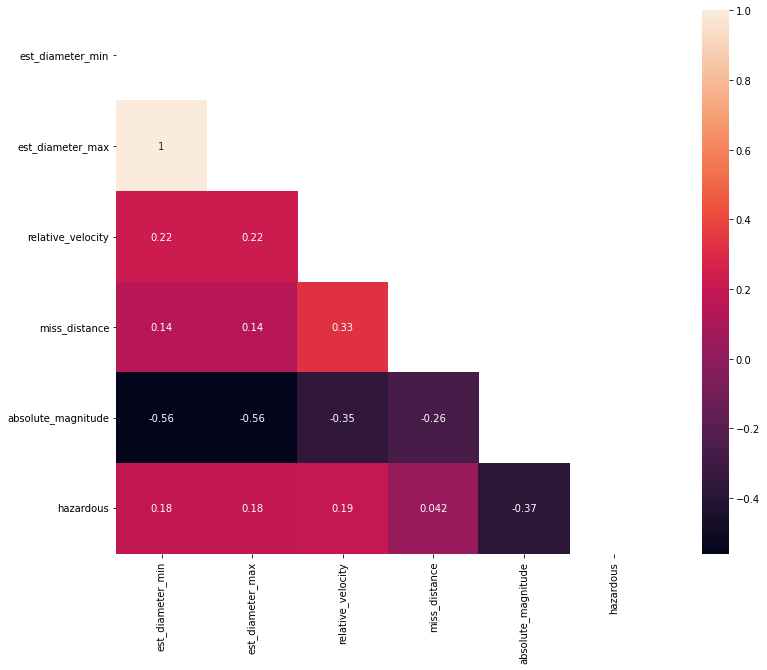

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(mask=mask, annot=True, data=df.corr(), square=True)

There is pretty good negative corelation result in absolute magnitude close to -0.4. **There is also a function correaltion between est_diameter_max and est_diameter_min. These two are mutually unambiguous.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf165fccd0>,
      dtype=object)

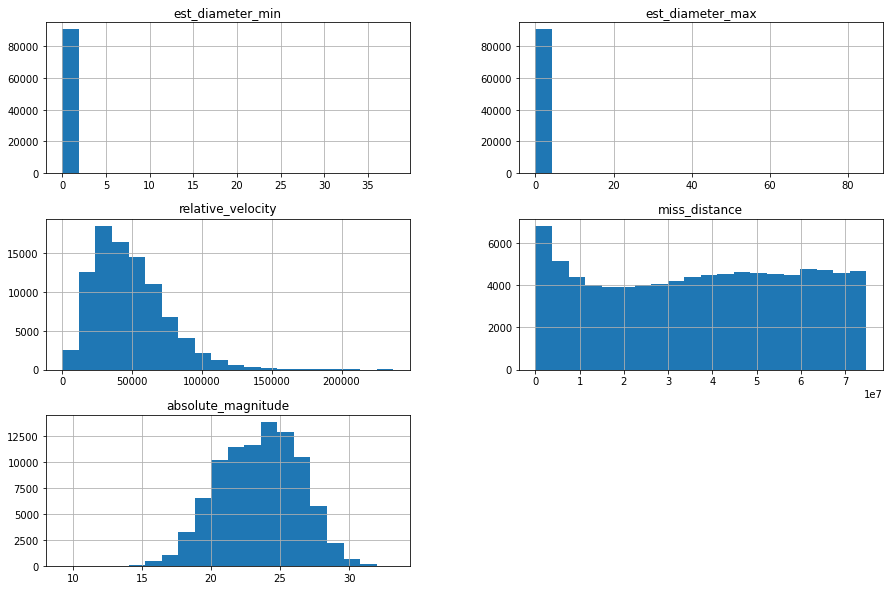

In [19]:
df.hist(bins=20, figsize=(15,10))

As it could have been seen, two columns are normally distributed and one is continously distributed. I will use diffrent standarization method on them. Before it I will drop one of columns which are mutually unambiguous and which would result in non-compliance with the principle of nonlinearity between vectors in regression models

In [20]:
df.drop(columns='est_diameter_min', inplace=True)

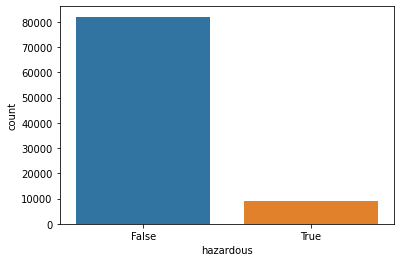

In [21]:
sns.countplot(x='hazardous', data=df)

Target column is imbalanced. 

In [22]:
from sklearn.preprocessing import *

cols_to_standard_scaling = ['relative_velocity', 'absolute_magnitude']
cols_to_log_scaling = ['est_diameter_max', 'miss_distance']

std_scaler = StandardScaler()
log_scaler = PowerTransformer()

# fitting both tranforms and applying them on the train set
std_scaler.fit(df[cols_to_standard_scaling])
log_scaler.fit(df[cols_to_log_scaling])

df[cols_to_standard_scaling] = pd.DataFrame(std_scaler.transform(df[cols_to_standard_scaling]),
                                                columns=cols_to_standard_scaling)
df[cols_to_log_scaling] = pd.DataFrame(log_scaler.transform(df[cols_to_log_scaling]),
                                            columns=[cols_to_log_scaling])

est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64


In [23]:
import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

y = df['hazardous']
df.drop(columns=['hazardous'], inplace=True)
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [24]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

y_train.value_counts()


(81752, 4) (9084, 4)
(81752,) (9084,)


False    73774
True      7978
Name: hazardous, dtype: int64

In [26]:
'''
cols_to_standard_scaling = ['relative_velocity', 'absolute_magnitude']
cols_to_log_scaling = ['est_diameter_max', 'miss_distance']

std_scaler = StandardScaler()
log_scaler = PowerTransformer()

# fitting both tranforms and applying them on the train set
std_scaler.fit(X_train[cols_to_standard_scaling])
log_scaler.fit(X_train[cols_to_log_scaling])

X_train[cols_to_standard_scaling] = pd.DataFrame(std_scaler.transform(X_train[cols_to_standard_scaling]),
                                                columns=cols_to_standard_scaling)
X_train[cols_to_log_scaling] = pd.DataFrame(log_scaler.transform(X_train[cols_to_log_scaling]),
                                            columns=[cols_to_log_scaling])
print(X_train.isna().sum())

# apllying transform with parameters from train set on test data
X_test[cols_to_standard_scaling] = pd.DataFrame(std_scaler.transform(X_test[cols_to_standard_scaling]),
                                                columns=cols_to_standard_scaling)
X_test[cols_to_log_scaling] = pd.DataFrame(log_scaler.transform(X_test[cols_to_log_scaling]),
                                          columns=[cols_to_log_scaling])
print(X_test.isna().sum())
'''



"\ncols_to_standard_scaling = ['relative_velocity', 'absolute_magnitude']\ncols_to_log_scaling = ['est_diameter_max', 'miss_distance']\n\nstd_scaler = StandardScaler()\nlog_scaler = PowerTransformer()\n\n# fitting both tranforms and applying them on the train set\nstd_scaler.fit(X_train[cols_to_standard_scaling])\nlog_scaler.fit(X_train[cols_to_log_scaling])\n\nX_train[cols_to_standard_scaling] = pd.DataFrame(std_scaler.transform(X_train[cols_to_standard_scaling]),\n                                                columns=cols_to_standard_scaling)\nX_train[cols_to_log_scaling] = pd.DataFrame(log_scaler.transform(X_train[cols_to_log_scaling]),\n                                            columns=[cols_to_log_scaling])\nprint(X_train.isna().sum())\n\n# apllying transform with parameters from train set on test data\nX_test[cols_to_standard_scaling] = pd.DataFrame(std_scaler.transform(X_test[cols_to_standard_scaling]),\n                                                columns=cols_to_standar

#Skąd nany sie tutaj biorą?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf10da0610>,
      dtype=object)

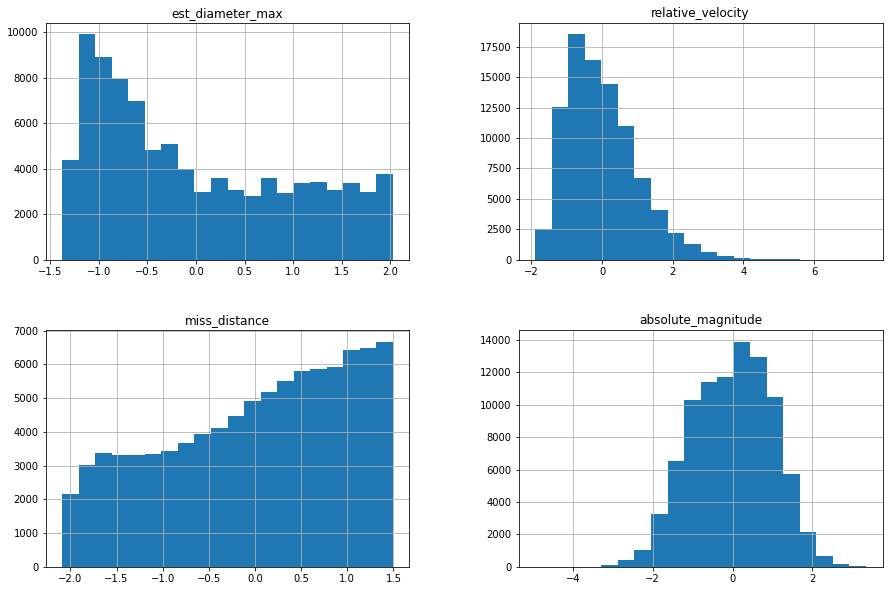

In [27]:
df.hist(bins=20, figsize=(15,10))

Lets look at the (im)balancing of target column
#Zrobić oversampling zamiast undersamplingu

In [28]:


# fristly concating again the X_train and y_train 
train = pd.concat([X_train, y_train], axis=1)

# size of each class
target_count_0, target_count_1 = train.hazardous.value_counts()

# separating claass
train_with_target_0 = train[train['hazardous'] == 0]
train_with_target_1 = train[train['hazardous'] == 1]

# sampling random rows from majority class and creating new df
train_under = train_with_target_0.sample(target_count_1)

# concating undersampled major class with minor class
train_sampled = pd.concat([train_under, train_with_target_1], axis=0)



In [29]:
train_sampled

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
39878,0.515406,-0.456758,1.315588,-0.527666,False
49166,1.258222,-0.769278,-0.021667,-1.049423,False
8178,-1.339677,1.640489,0.421924,2.478481,False
62260,-0.791504,-0.148071,-1.212585,0.612596,False
74589,-1.045520,0.435717,-1.720208,1.061791,False
...,...,...,...,...,...
14181,0.746448,0.633888,-1.275853,-0.683157,True
21478,1.163892,-0.031977,-0.633011,-0.976861,True
32239,1.380183,2.288425,0.857437,-1.149628,True
5947,0.566722,0.259191,1.227819,-0.562220,True


Trying to oversmaple the minority class

In [30]:
'''
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42,)
X_res, y_res = sm.fit_resample(X_train, y_train)
'''


'\nfrom imblearn.over_sampling import SMOTE\nsm = SMOTE(random_state=42,)\nX_res, y_res = sm.fit_resample(X_train, y_train)\n'

Sampling worked well. There is nearly 16k of records with, non duplicated data as it would be with oversampliing, however some part of data was lost. Spltting train set into to feature and target columns again.  

In [ ]:
y_train = train_sampled.hazardous
train_sampled.drop(columns='hazardous', inplace=True)
X_train = train_sampled

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
classifier = RandomForestClassifier(class_weight='balanced')

score_train = cross_val_score(classifier, X_train, y_train, scoring='f1')
print(f'Accuracy for test set: {score_train.mean()}')

score_test = cross_val_score(classifier, X_test, y_test, scoring='f1')
print(f'f1 score for test set: {score_test.mean()}')

fitted_clf = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(f'Accuracy for trained estimator on test set: {accuracy_score(y_test, y_pred)}')
print(f'f1 score for trained estimator on test set: {f1_score(y_test, y_pred)}')



Accuracy for test set: 0.8730615630144081
f1 score for test set: 0.2914465330734951
Accuracy for trained estimator on test set: 0.8087846763540291
f1 score for trained estimator on test set: 0.47822168819465305


There over 2 times increase in one of metrics between trained and untrained estmiator for RandomForsetClf

In [35]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, 
                        title, 
                        X, 
                        y, 
                        axes=None, 
                        ylim=None, 
                        cv=None, 
                        n_jobs=None, 
                        train_sizes=np.linspace(0.1, 1.0, 5)):
  
  if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

  axes[0].set_title(title)
  if ylim is not None:
        axes[0].set_ylim(*ylim)

  axes[0].set_xlabel("Training examples")
  axes[0].set_ylabel("Score")


  # using predefined function to create a tuple of needed variables
  train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
  )

  # calcualting means and std's of each variables separately
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)


    # LEARNING CURVE
  axes[0].grid()
  axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
        )
  axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
        ) 
  axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
  axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
  axes[0].legend(loc="best")

    # No SAMPLE'S VS FIT TIME
  axes[1].grid()
  axes[1].plot(train_sizes, fit_times_mean, "o-")
  axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
  axes[1].set_xlabel("Training examples")
  axes[1].set_ylabel("fit_times")
  axes[1].set_title("Scalability of the model")

    # FIT_TIME VS SCORE
  fit_time_argsort = fit_times_mean.argsort()
  fit_time_sorted = fit_times_mean[fit_time_argsort]
  test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
  test_scores_std_sorted = test_scores_std[fit_time_argsort]
  axes[2].grid()
  axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
  axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
  axes[2].set_xlabel("fit_times")
  axes[2].set_ylabel("Score")
  axes[2].set_title("Performance of the model")

  return plt

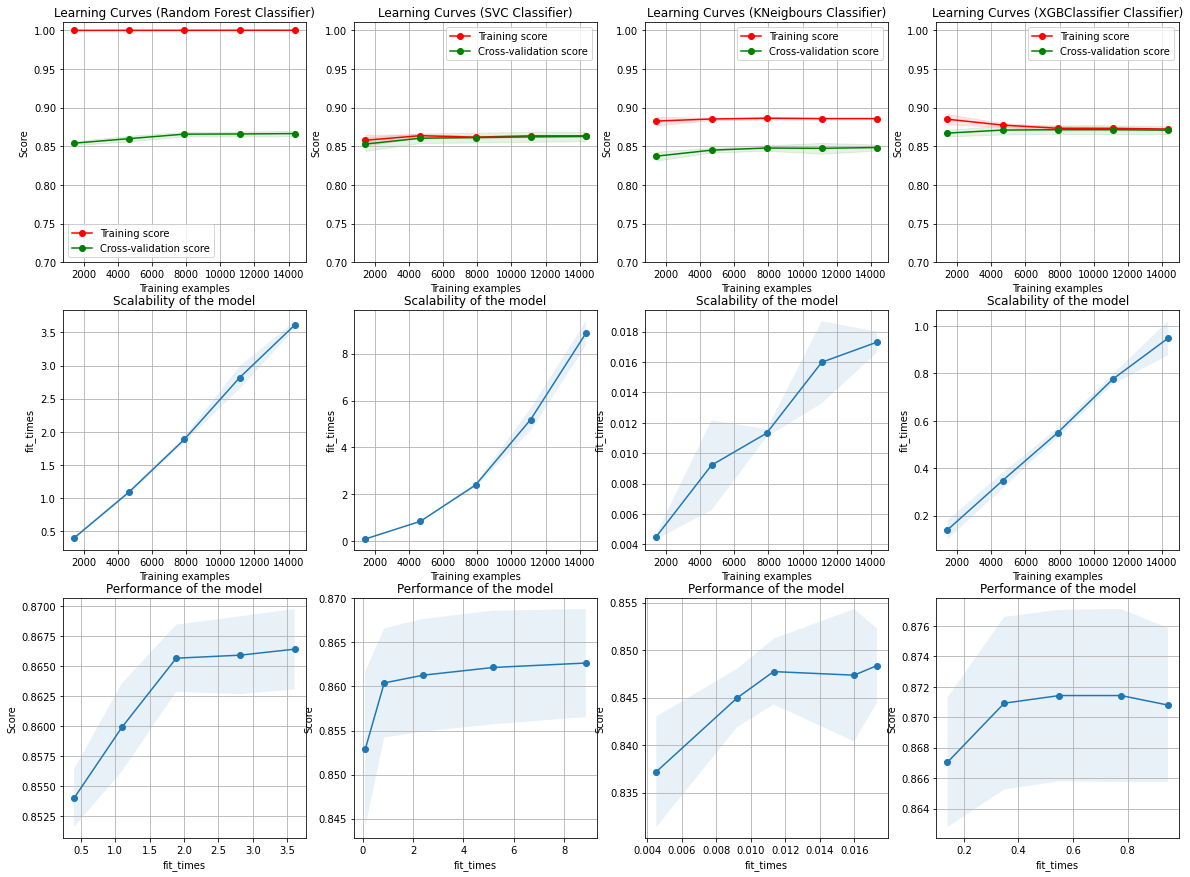

In [36]:
from sklearn.model_selection import ShuffleSplit

fig, axes = plt.subplots(3, 4, figsize=(20, 15))


# --------Random forest ClF-------------
estimator = RandomForestClassifier()
title = "Learning Curves (Random Forest Classifier)"
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)

plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=-1
)


# --------SVC-------------
from sklearn.svm import SVC

estimator = SVC()
title = "Learning Curves (SVC Classifier)"
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)

plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=-1
)


# --------KNeighborsClassifier-------------
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
title = "Learning Curves (KNeigbours Classifier)"
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)

plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=-1
)

# --------XGBClassifier-------------
from xgboost import XGBClassifier
estimator = XGBClassifier()
title = "Learning Curves (XGBClassifier Classifier)"
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)

plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:, 3], ylim=(0.7, 1.01), cv=cv, n_jobs=-1
)

plt.show()

Two of models nicely converges on plots. Especially KNeigbours. All of models oscilates between the similar accuracy scores.

As can be also observed learning curves are really flatered. That can be the result of resampling. There are nearly equal number of both lables in target column. Carindality of train set does not seem to have a key impact on learning curves, however the scores are pretty good. I can choose one of best resuting classifier and print the claisification resport to see what is are the other metrics.

# Closer look at XGBClassifier curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

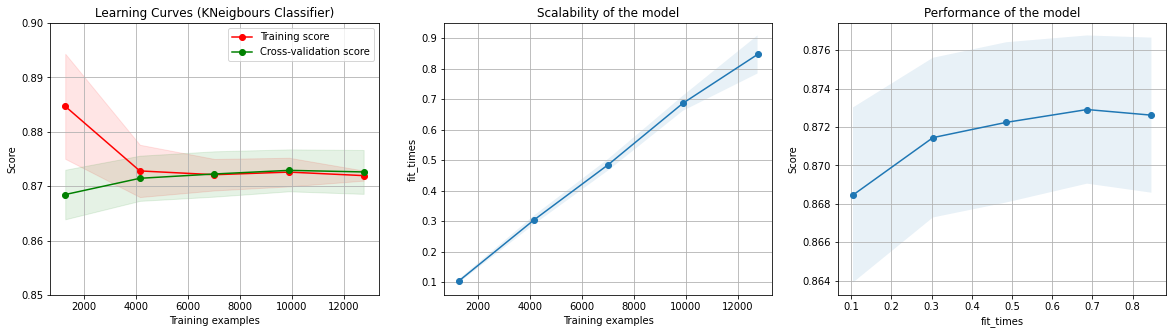

In [37]:
estimator = XGBClassifier()

title = "Learning Curves (KNeigbours Classifier)"
cv = ShuffleSplit(n_splits=15, test_size=0.2, random_state=0)

plot_learning_curve(
    estimator, title, X_train, y_train, ylim=(0.85, 0.9), cv=cv, n_jobs=-1
)

Now there is a better view on changes in score accuracy as a function of number of exmamples. Learning curves nearly touch themselves. Validation score plot didn't exceed the level of trainng score - there was not an overfitting case.

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.80      0.88      8222
        True       0.33      0.94      0.49       862

    accuracy                           0.81      9084
   macro avg       0.66      0.87      0.68      9084
weighted avg       0.93      0.81      0.85      9084



Altough resampling in the train set f_1 metrics is a bit less than 0.5 what is a strong average score. Tryin to increase this metrics by hypertuning chosen classifier.


# Using hyperopt module to fasten searching for optimal parameters for a chosen classifier.

Defininig space to search-thru

In [66]:
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval, Trials
import random
from hyperopt.pyll import scope

# deifning some dict of classifiers and their parameters 
classifiers = [
    {
        'name': 'XGBClassifier()',
        'class': XGBClassifier(),
        'max_evals': 100,
        'params' : {
            'learning_rate': hp.loguniform ('learning_rate', 0.005, 0.25),
            'max_depth': hp.choice('max_depth', np.arange(2, 11).tolist()),
            'min_child_weight': hp.choice('min_child_weight', np.arange(0, 150).tolist()),
            'gamma': hp.loguniform('gamma', 0.0, 2.0),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', 0.0, 4.0),
            'reg_lambda': hp.loguniform('reg_lambda', 0.0, 4.0)
        }
    } 
]


Defining pipeline with params as above, as well as loss function for hyperopt module

In [67]:
from sklearn.pipeline import Pipeline

def objective(space):
  # here some pipelione could have been specified
  pipe_params = {}

  for s in space:
    pipe_params[f"classifier__{s}"] = space[s]

  pipeline.set_params(**pipe_params)

  score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1').mean()

  # Thus the scoring is f1 metric the loss function will be 1-f1_score

  return {'loss':1-score, 'status': STATUS_OK, 'accuracy': score}

Defninf function to search-thru created space and saving each params 

In [68]:
trials_df = []
 
for cl in classifiers:
    cl_name = cl['class'].__class__.__name__
    print(f"\n\n{cl_name}")
 
    pipeline = Pipeline(steps=[
                               ('classifier', 
                              cl['class'])])
 
    space = {}
    for k in cl['params']:
        space[k] = cl['params'][k]
 
    max_evals = cl['max_evals']
 
    trials = Trials()
    best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
 
    best_params = space_eval(space, best)
    print('\nThe best params:')
    print ("{:<30} {}".format('Parameter','Selected'))
    for k, v in best_params.items():
        print ("{:<30} {}".format(k, v))
 
    for trial in trials.trials:
        trials_df.append({
            'classifier': cl_name,
            'loss': trial['result']['loss'],
            'accuracy': trial['result']['accuracy'],
            'params': trial['misc']['vals']
            })



XGBClassifier
100%|██████████| 100/100 [03:43<00:00,  2.24s/it, best loss: 0.11549284476878297]

The best params:
Parameter                      Selected
colsample_bylevel              0.8486910440800904
colsample_bytree               0.7331380650338675
gamma                          2.0233977550430313
learning_rate                  1.1019078839268357
max_depth                      7
min_child_weight               2
reg_alpha                      7.030216875611883
reg_lambda                     13.942618825203546
subsample                      0.630651138337596


It can be noticed, which of tested models occured to evaluate the best f1 metric. To see better the results of hyperopt, it will be visualized in a simple plot.

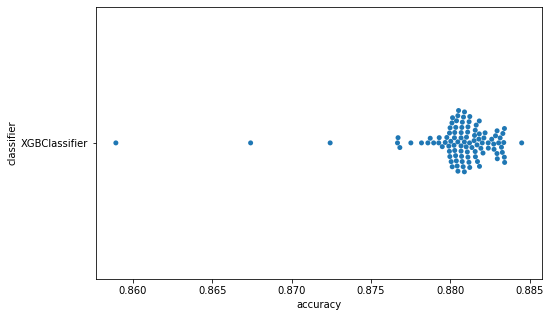

In [69]:
trials_df = pd.DataFrame(trials_df)

plt.figure(figsize=(8,5))
sns.swarmplot(data=trials_df, y='classifier', x='accuracy')

In term on fully checking selected model how it struggle with inputed data, some charts with each hyperparamter can be made.

In [70]:
selected_clf = trials_df[trials_df['classifier']=='XGBClassifier'][['accuracy', 'params']]

selected_clf = pd.concat([selected_clf[['accuracy']], selected_clf.params.apply(pd.Series)], axis=1)
selected_clf.rename(columns={'accuracy':'f1_score'}, inplace=True)

for col in selected_clf.select_dtypes(include=[list]).columns:
   selected_clf[col] = selected_clf[col].apply(lambda x: x[0])
    
selected_clf_plots = selected_clf.melt(id_vars='f1_score', var_name='param', value_name='value')

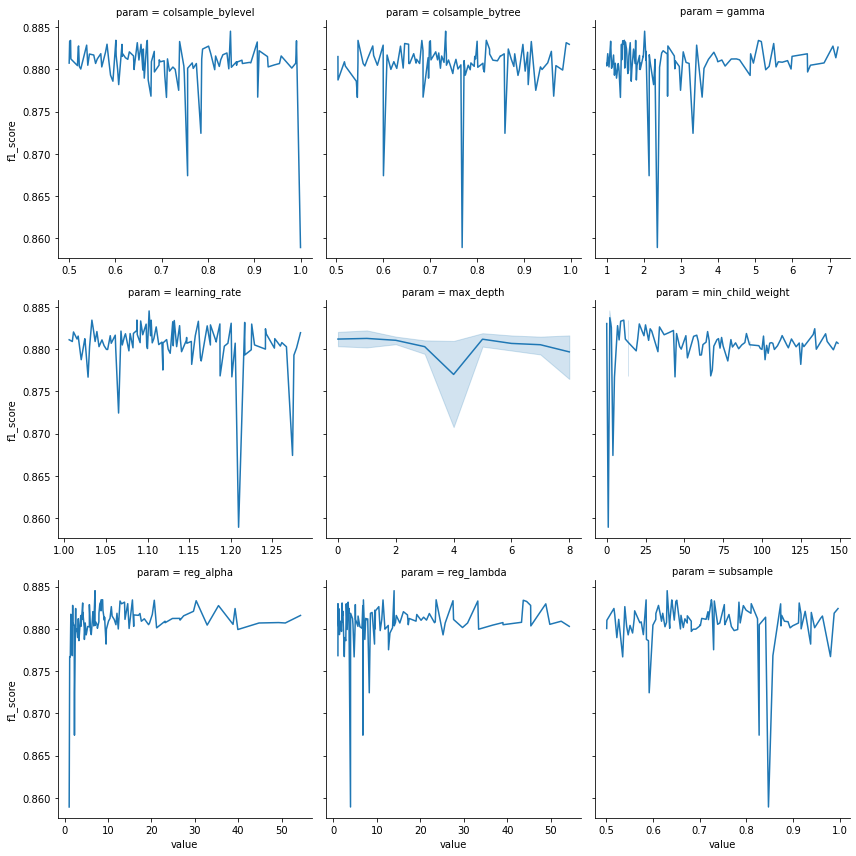

In [71]:
m = sns.FacetGrid(selected_clf_plots, col='param', sharex=False, col_wrap=3, height=4)

m.map(sns.lineplot, 'value', 'f1_score')

For the paramter 'subsmaple' the density of higher scores are located in specific corner which can be show us that model performs better for closer to '1' subsample value. Moreover for parameter 'gamma' scores also seem to be located in narrower range of top scores. Range of change for diffrent type of parametres vary from 0.86 to 0.885. Hence there is a 0.02 f_1 score improvement depending on case.

Now, the best performing model can be trained and evaluated on test set.



In [72]:
best_params_estimator = XGBClassifier(**best_params).fit(X_train, y_train)

y_pred_final = best_params_estimator.predict(X_test)
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

       False       1.00      0.77      0.87      8222
        True       0.31      0.97      0.47       862

    accuracy                           0.79      9084
   macro avg       0.65      0.87      0.67      9084
weighted avg       0.93      0.79      0.83      9084



Altought the try to tune one of previously tested classifiers it does not performed any better. However showed steps may be a part of a whole ML flow. There has been implemented learning rate functions, which also show fit time in functions of number of examples. To get better results in hyperparameters tuning  - to imporve accuracy and f1 metrics there might have been used a larger number of train samples (without resampling, where part of information about majority class was lost). On the other hand there could have been used other estimator to focus on in hyper param's tuning.
